# Wikipedia Recomendation Systems

# Code part:

## Imports

In [148]:
import requests
import bs4
import re
from time import sleep
import random
import networkx as nx
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from google.colab import drive
import csv
import sys
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Input

In [149]:
links = ['https://en.wikipedia.org/wiki/Wikipedia:Unusual_articles']

## Crawling and scraping

In [150]:
def find_all_link(link, max_pages = 5000):
  response = requests.get(link)
  parsed = bs4.BeautifulSoup(response.text)
  links = parsed.find_all('a', attrs={'href': re.compile(r'^/wiki')})
  visited = set()
  stack = set()
  stack.add(link)
  ret = set()
  ret.add(link)
  while stack:
    page = stack.pop()
    if page not in visited:
      visited.add(page)
      ret.add(page)
      response = requests.get(page)
      parsed = bs4.BeautifulSoup(response.text)
      links = parsed.find_all('a', attrs={'href': re.compile(r'^/wiki')})
      for i in links:
        if len(ret) >= max_pages:
          return list(ret)
        stack.add('https://en.wikipedia.org' + i['href'])
        ret.add('https://en.wikipedia.org' + i['href'])

def find_all_links(links, max_pages = 1000):
  ret = set()
  for link in links:
    ret.update(find_all_link(link, max_pages))
  return list(ret)

def get_text_from_link(link):
  response = requests.get(link)
  response.raise_for_status()

  parsed = bs4.BeautifulSoup(response.text, 'html.parser')
  paragraphs = parsed.select('p')
  article_text = ''.join(p.getText() for p in paragraphs)
  return article_text

def get_text_from_links(links):
  return [(link, get_text_from_link(link)) for link in links]

## Stemming, lemmatization

In [151]:
def process_document(document):
  porter = PorterStemmer()
  words = word_tokenize(document)

  stop_words = set(stopwords.words('english'))
  filtered_words = [word for word in words if word.lower() not in stop_words]

  stemmed_words = [porter.stem(word) for word in filtered_words]
  processed_text = ' '.join(stemmed_words)

  return processed_text

def process_documents(documents):
  return [(name, process_document(document)) for name, document in documents]

## Similarities

In [152]:
def most_simillar_document(querry, documents):
  query_df = pd.DataFrame(tfidf.transform([querry]).toarray(), columns=documents.columns)
  similarity_scores = cosine_similarity(query_df, documents).flatten()
  document_scores = list(zip(documents.index, similarity_scores))
  sorted_documents = sorted(document_scores, key=lambda x: x[1], reverse=True)

  return sorted_documents

def most_simillar_documents(querries, documents):

  return [[querry, most_simillar_document(querry, documents)] for querry in querries]

## Get data to csv

In [153]:
#scraped_links = find_all_links(links, max_pages = 1000)
#documents = get_text_from_links(scraped_links)
#processed_documents = process_documents(documents)

#drive.mount('/content/gdrive')
#csv_file_path = '/content/gdrive/My Drive/processed_documents.csv'
#with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
#    csv_writer = csv.writer(csvfile)
#    csv_writer.writerows([(name, doc) for name, doc in processed_documents])

## Main algorithm, where for each querry the best one is selected

In [160]:
querries = ['https://en.wikipedia.org/wiki/Poland', 'https://en.wikipedia.org/wiki/Katy_Perry', 'https://en.wikipedia.org/wiki/Horror_fiction', 'https://en.wikipedia.org/wiki/Computer']
csv_file_path = '/content/gdrive/My Drive/processed_documents.csv'
documents = []
csv.field_size_limit(sys.maxsize)


with open(csv_file_path, 'r', newline='', encoding='utf-8') as csvfile:
  csv_reader = csv.reader(csvfile)
  next(csv_reader, None)

  for row in csv_reader:
    documents.append(row)



querries_text = get_text_from_links(querries)
processed_querries = process_documents(querries_text)

querries_text = [document[1] for document in processed_querries]
querries_name = [document[0] for document in processed_querries]

documents_text = [document[1] for document in documents]
documents_name = [document[0] for document in documents]

tfidf=TfidfVectorizer(use_idf=True, smooth_idf=False)
df = pd.DataFrame(tfidf.fit_transform(documents_text).toarray(), index=documents_name, columns=tfidf.get_feature_names_out())

results = most_simillar_documents(querries_text, df)

for i, (querry, page) in enumerate(results):
  print(f"For querry: {querries_name[i]} best found page is: {page[0]}")

For querry: https://en.wikipedia.org/wiki/Poland best found page is: ('https://en.wikipedia.org/wiki/Poland', 1.0000000000000007)
For querry: https://en.wikipedia.org/wiki/Katy_Perry best found page is: ('https://en.wikipedia.org/wiki/Cult_following', 0.1906373403144635)
For querry: https://en.wikipedia.org/wiki/Horror_fiction best found page is: ('https://en.wikipedia.org/wiki/The_Thing_from_Another_World', 0.10269378353631864)
For querry: https://en.wikipedia.org/wiki/Computer best found page is: ('https://en.wikipedia.org/wiki/Capitol_Hill%27s_mystery_soda_machine', 0.12542879361533174)


## Main algorithm where querries are joined together

In [161]:
querry_list = ['https://en.wikipedia.org/wiki/Poland', 'https://en.wikipedia.org/wiki/Katy_Perry', 'https://en.wikipedia.org/wiki/Horror_fiction', 'https://en.wikipedia.org/wiki/Computer']

querries_text = get_text_from_links(querries)
processed_querries = process_documents(querries_text)

querries_text = [document[1] for document in processed_querries]
querries_name = [document[0] for document in processed_querries]

documents_text = [document[1] for document in documents]
documents_name = [document[0] for document in documents]

tfidf=TfidfVectorizer(use_idf=True, smooth_idf=False)
df = pd.DataFrame(tfidf.fit_transform(documents_text).toarray(), index=documents_name, columns=tfidf.get_feature_names_out())

results = most_simillar_documents([''.join(querries_text)], df)

for i, (querry, page) in enumerate(results):
  print(f"For querry: {querry_list} best found pages are:")
  for j in range(5):
    print(f"Page nr {j}: {page[j]}")

For querry: ['https://en.wikipedia.org/wiki/Poland', 'https://en.wikipedia.org/wiki/Katy_Perry', 'https://en.wikipedia.org/wiki/Horror_fiction', 'https://en.wikipedia.org/wiki/Computer'] best found pages are:
Page nr 0: ('https://en.wikipedia.org/wiki/Poland', 0.5613939846882504)
Page nr 1: ('https://en.wikipedia.org/wiki/United_States', 0.25332508642828055)
Page nr 2: ('https://en.wikipedia.org/wiki/Kielce_Bus_Station', 0.2149201823657025)
Page nr 3: ('https://en.wikipedia.org/wiki/Europe', 0.20776756734075433)
Page nr 4: ('https://en.wikipedia.org/wiki/Greetings_from_Jerusalem_Avenue', 0.20476306671173589)


# Analysis Part:

# How does algorithm work:
I scraped text from 1000 wikipedia articles using BFS that stem from 'https://en.wikipedia.org/wiki/Wikipedia:Unusual_articles', I chose it because I decided I want user to have unique and interesting articles presented to them.

Next, using PorterStemmer combined with deletion of stop words I preprocessed them, along with respective querries.

Lastly for finding similarities, I used TFIDF table combined with cosine simillarity to find most suitable article. In case of multiple querries I decided to code 2 different approaches. In the first one user provides list of querries and for each of them, the single best article is returned. For second approach, all querries are combined to one, simulating user browsing through wikipedia.

# Interesting statistics from data:



What are most frequent words in those articles?

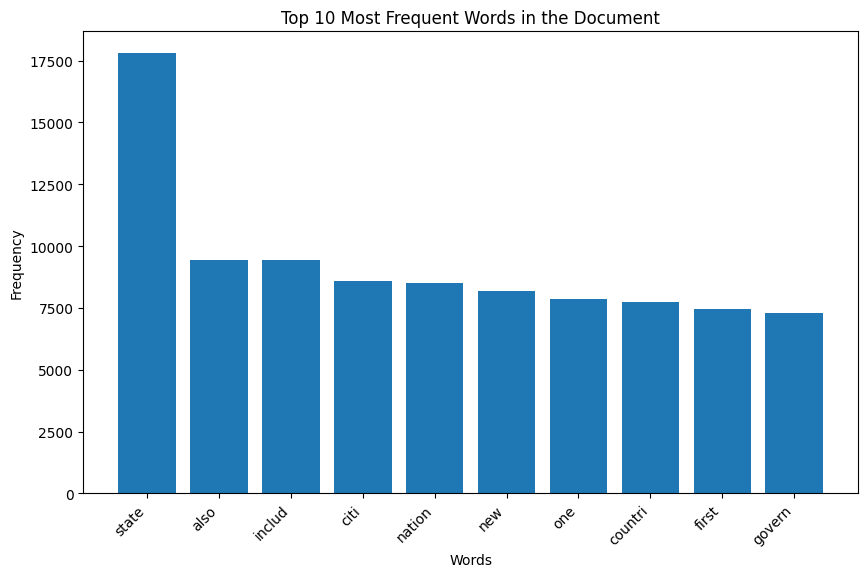

In [156]:
text = ' '.join([document[1] for document in documents])
tokens = word_tokenize(text)
stop_words = set(stopwords.words('english'))
filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

word_freq = Counter(filtered_tokens)

top_words = word_freq.most_common(10)


plt.figure(figsize=(10, 6))
plt.bar(*zip(*top_words))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Words in the Document')
plt.xticks(rotation=45, ha='right')
plt.show()

A lot of words that describe countries appear there because in initial document there are a lot of articles about geography.

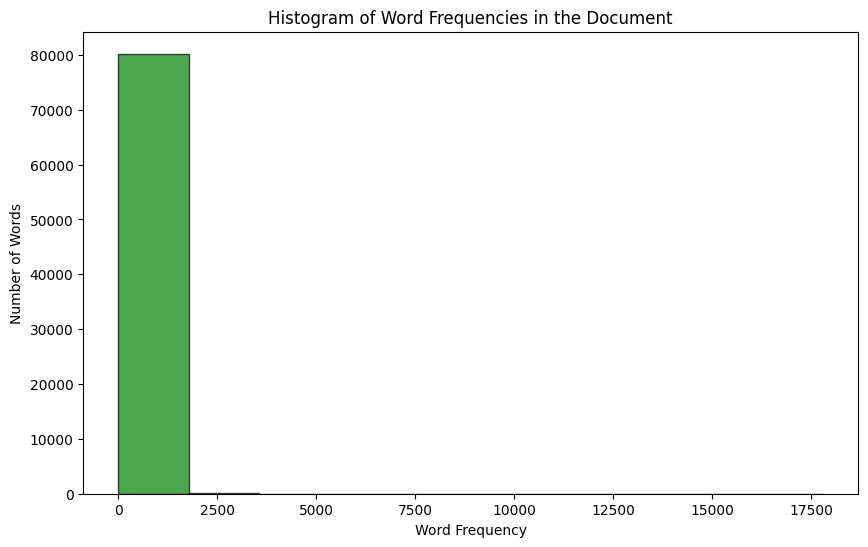

In [157]:
tokens = word_tokenize(text)

stop_words = set(stopwords.words('english'))
filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

word_freq = Counter(filtered_tokens)

plt.figure(figsize=(10, 6))
plt.hist(word_freq.values(), bins=10, color='green', edgecolor='black', alpha=0.7)
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.title('Histogram of Word Frequencies in the Document')
plt.show()

Plot shows taht most words only appear one time, wich makes sense. There are a lot of words specifically tied to a particular article.

In [158]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform([document[1] for document in documents])

target_articles = [document[0] for document in documents[0:5]]
target_articles += ['https://en.wikipedia.org/wiki/Poland']

cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

important_words = tfidf_vectorizer.get_feature_names_out()

for target_article in target_articles:
    article_index = [document[0] for document in documents].index(target_article)
    word_weights = list(zip(important_words, tfidf_matrix[article_index].toarray()[0]))
    word_weights.sort(key=lambda x: x[1], reverse=True)
    top_words_contributions = word_weights[:10]

    print(f"\nTop contributing words for '{target_article}':")
    for word, weight in top_words_contributions:
        print(f"{word}: {weight:.4f}")


Top contributing words for 'https://en.wikipedia.org/wiki/Shani_Shingnapur':
shani: 0.7012
shingnapur: 0.3322
templ: 0.1810
lord: 0.1503
swayambhu: 0.1476
villag: 0.1435
shepherd: 0.1354
devote: 0.1147
theft: 0.1121
shanaishwara: 0.1107

Top contributing words for 'https://en.wikipedia.org/wiki/Castle_Doctrine_in_the_United_States':
forc: 0.3570
person: 0.3373
unlaw: 0.2963
deadli: 0.2902
use: 0.2231
law: 0.2121
dwell: 0.1937
reason: 0.1680
justifi: 0.1540
doctrin: 0.1438

Top contributing words for 'https://en.wikipedia.org/wiki/Wendy%27s':
wendi: 0.8652
restaur: 0.1895
menu: 0.1653
sandwich: 0.0994
patti: 0.0973
hamburg: 0.0913
breakfast: 0.0907
chain: 0.0821
open: 0.0644
thoma: 0.0623

Top contributing words for 'https://en.wikipedia.org/wiki/Sovereign_Military_Order_of_Malta':
order: 0.5451
malta: 0.3338
grand: 0.2820
knight: 0.2398
master: 0.2305
sovereign: 0.1666
priori: 0.1526
hospital: 0.1252
pope: 0.1146
cardin: 0.0972

Top contributing words for 'https://en.wikipedia.org/wik

I also implemented function that shows most important words for each article in database. Most of them are as expected very specific words tied to concept presented in article. It is seen in Poland article. Som of those words are poland, warsaw or europe